In [139]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [140]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [141]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [142]:
import pandas as pd

In [143]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [144]:
df = pd.read_csv("/content/drive/MyDrive/ColabData/kaggle-titanic/train.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [145]:
def makeDataList(csv_path):
  datalist = pd.read_csv(csv_path)
  datalist = datalist.drop(["Name", "Ticket", "Cabin"], axis=1)
  datalist = pd.get_dummies(datalist)
  datalist = datalist.fillna(-1)
  return datalist

In [146]:
datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-titanic/train.csv")

In [147]:
datalist.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [148]:
from sklearn.model_selection import train_test_split

train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)

In [149]:
print(train_datalist.shape)
print(val_datalist.shape)
print(train_datalist.values)
train_datalist.head()

(801, 12)
(90, 12)
[[268.   1.   3. ...   0.   0.   1.]
 [636.   1.   2. ...   0.   0.   1.]
 [474.   1.   2. ...   1.   0.   0.]
 ...
 [295.   0.   3. ...   0.   0.   1.]
 [724.   0.   2. ...   0.   0.   1.]
 [816.   0.   1. ...   0.   0.   1.]]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
267,268,1,3,25.0,1,0,7.7750,0,1,0,0,1
635,636,1,2,28.0,0,0,13.0000,1,0,0,0,1
473,474,1,2,23.0,0,0,13.7917,1,0,1,0,0
207,208,1,3,26.0,0,0,18.7875,0,1,1,0,0
290,291,1,1,26.0,0,0,78.8500,1,0,0,0,1


In [150]:
#DataFrameからndarrayに変換.　Datasetを継承し，DataLoaderの第一引数にできる．
class DatasetMaker(Dataset):
  def __init__(self, datalist):
    self.input_datalist = datalist.drop(["PassengerId", "Survived"], axis=1).values.astype(np.float32)
    self.label_datalist = datalist["Survived"].values.astype(np.float32)

  #lenを呼び出すための特殊メソッドで必須．
  def __len__(self):
    return len(self.input_datalist)

  #データセット内の特定の番号のinputs, labelsをndarray型で抽出できるようにする．
  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    labels = self.label_datalist[index]
    return inputs, labels

In [151]:
dataset = DatasetMaker(datalist)
print(dataset.__len__())
print(dataset.__getitem__(index=0)[0])
print(dataset.__getitem__(index=0)[1])

891
[ 3.   22.    1.    0.    7.25  0.    1.    0.    0.    1.  ]
0.0


In [152]:
dataset

In [153]:
batch_size = 5
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
for inputs2, labels2 in dataloader:
  break
#batch_itr = iter(dataloader)
#inputs, labels = next(batch_itr)

In [154]:
print(inputs2)
print(inputs2.size())
print(labels2)
print(labels2.size())

tensor([[ 3.0000, 19.0000,  0.0000,  0.0000,  7.8792,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000],
        [ 2.0000, 34.0000,  1.0000,  0.0000, 21.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000],
        [ 2.0000, 25.0000,  0.0000,  0.0000, 13.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000],
        [ 3.0000, 28.0000,  1.0000,  1.0000, 14.4000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000],
        [ 3.0000, 24.5000,  0.0000,  0.0000,  8.0500,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000]])
torch.Size([5, 10])
tensor([1., 0., 0., 0., 0.])
torch.Size([5])


In [155]:
class Net(nn.Module):
  def __init__(self, n_input, n_output, n_hidden, dropout_rate=0.1):
    super().__init__()
    self.l1 = nn.Linear(n_input, n_hidden)
    self.relu = nn.ReLU(inplace=True)
    self.l2 = nn.Linear(n_hidden, n_output)
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self, x):
    x = self.classifier(x)
    return x

In [156]:
n_input = len(dataset.__getitem__(index=0)[0])
n_output = 1
n_hidden = 64

In [157]:
net = Net(n_input, n_output, n_hidden)

In [158]:
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[ 2.3557e-01,  3.0603e-01, -3.0221e-01,  1.1585e-01,  1.7822e-01,
          1.4800e-01, -9.8207e-02, -2.5085e-01,  2.8414e-03,  2.9635e-01],
        [ 2.9734e-01,  6.8191e-02,  3.4762e-02, -1.7961e-01, -2.4529e-01,
          1.2314e-01,  1.5699e-02, -1.4861e-01,  2.6066e-01,  8.1253e-02],
        [ 2.5234e-01,  5.5463e-02,  3.7583e-02, -6.1819e-02,  9.8573e-02,
         -1.9030e-01, -9.0893e-03,  2.0761e-02, -5.3934e-02, -8.6833e-02],
        [ 1.3529e-01, -2.4807e-02,  2.4442e-01,  2.9469e-01, -1.0615e-01,
         -2.5487e-02,  1.3621e-01,  7.3426e-02, -2.9090e-01, -1.7877e-01],
        [-2.6615e-01,  2.1004e-01,  4.4120e-02,  2.6819e-01,  8.1868e-02,
         -2.5498e-01,  1.5419e-01, -2.5286e-02,  2.7527e-01, -1.4120e-01],
        [ 2.8829e-01,  1.5308e-01,  1.2607e-01, -1.2150e-01, -1.7544e-01,
          1.6488e-01,  1.0687e-01, -2.9145e-01, -1.8421e-01, -3.7288e-02],
        [ 5.3875e-02,  1.3579e-01,  2.1776e-01,  2.9706e-02, -3.2187e-

In [159]:
print(net)

Net(
  (l1): Linear(in_features=10, out_features=64, bias=True)
  (relu): ReLU(inplace=True)
  (l2): Linear(in_features=64, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [160]:
summary(net, (n_input, ))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Sequential: 1-1                        [1]                       --
│    └─Linear: 2-1                       [64]                      704
│    └─ReLU: 2-2                         [64]                      --
│    └─Linear: 2-3                       [1]                       65
Total params: 769
Trainable params: 769
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [161]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.001
optimizer = optim.Adam(net.parameters())

In [162]:
def eval_loss(dataloader, device, net, criterion):
  for inputs, labels in dataloader:
    break
  inputs = inputs.to(device)
  labels = labels.to(device)
  labels = labels.view(labels.shape[0], 1)
  #予測計算
  outputs = net(inputs)
  #損失計算
  loss = criterion(outputs, labels)
  return loss

In [163]:
eval_loss(dataloader, device, net, criterion)

tensor(1.1200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [164]:
def fit(net, optimizer, criterion, num_epochs, dataloader, device, history):
  from tqdm.notebook import tqdm
  base_epochs = 0 #len(history)
  for epoch in range(base_epochs, num_epochs+base_epochs):
    net.train()
    n_train_acc = 0
    train_loss = 0
    n_train = 0
    for inputs, labels in tqdm(dataloader):
      train_batch_size = len(labels)
      n_train += train_batch_size

      labels = labels.view(labels.shape[0], 1)
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      predicted = outputs > 0.5
      train_loss += loss.item() * train_batch_size
      n_train_acc += (predicted == labels).sum().item()
    train_acc = n_train_acc / n_train
    avg_train_loss = train_loss / n_train
    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, train_acc])
    history = np.vstack((history, item))
  return history


In [165]:
num_epochs = 50
history = np.zeros((0, 3))
history = fit(net, optimizer, criterion, num_epochs, dataloader, device, history)

  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.66057 acc: 0.65056


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.56628 acc: 0.67865


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.55139 acc: 0.69326


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.51907 acc: 0.71798


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.51543 acc: 0.72472


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.51509 acc: 0.73146


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.48279 acc: 0.75730


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.49101 acc: 0.76966


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.48863 acc: 0.76292


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.47126 acc: 0.78427


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.46840 acc: 0.79438


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.46332 acc: 0.80225


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.47174 acc: 0.77303


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.47208 acc: 0.78539


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.44793 acc: 0.79551


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.44845 acc: 0.80337


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.44716 acc: 0.80449


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.45448 acc: 0.79663


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.44466 acc: 0.81124


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.45475 acc: 0.80562


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.44782 acc: 0.80337


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.46529 acc: 0.79213


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.51199 acc: 0.79101


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.45314 acc: 0.79775


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.44241 acc: 0.81461


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.44260 acc: 0.80899


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.45817 acc: 0.79438


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.44325 acc: 0.80000


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.46295 acc: 0.79775


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.44908 acc: 0.80787


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.43306 acc: 0.80562


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.43777 acc: 0.79663


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.44079 acc: 0.80225


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45061 acc: 0.79551


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46146 acc: 0.79326


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.44073 acc: 0.80899


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.42955 acc: 0.80337


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44166 acc: 0.80337


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.43771 acc: 0.80562


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45181 acc: 0.79101


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.42877 acc: 0.80337


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43072 acc: 0.81124


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.42855 acc: 0.79326


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43964 acc: 0.80449


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43703 acc: 0.80337


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.44493 acc: 0.80000


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42540 acc: 0.79775


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42761 acc: 0.80449


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42337 acc: 0.81011


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42168 acc: 0.80562


In [166]:
def evaluate_history(history):
  #損失と精度の確認
  #print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
  #print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

  num_epochs = len(history)
  unit = num_epochs / 10

  # 学習曲線の表示 (損失)
  plt.figure(figsize=(9,8))
  plt.plot(history[:,0], history[:,1], 'b', label='訓練')
  #plt.plot(history[:,0], history[:,3], 'k', label='検証')
  plt.xticks(np.arange(0,num_epochs+1, unit))
  plt.xlabel('繰り返し回数')
  plt.ylabel('損失')
  plt.title('学習曲線(損失)')
  plt.legend()
  plt.show()

  # 学習曲線の表示 (精度)
  plt.figure(figsize=(9,8))
  plt.plot(history[:,0], history[:,2], 'b', label='訓練')
  #plt.plot(history[:,0], history[:,4], 'k', label='検証')
  plt.xticks(np.arange(0,num_epochs+1,unit))
  plt.xlabel('繰り返し回数')
  plt.ylabel('精度')
  plt.title('学習曲線(精度)')
  plt.legend()
  plt.show()

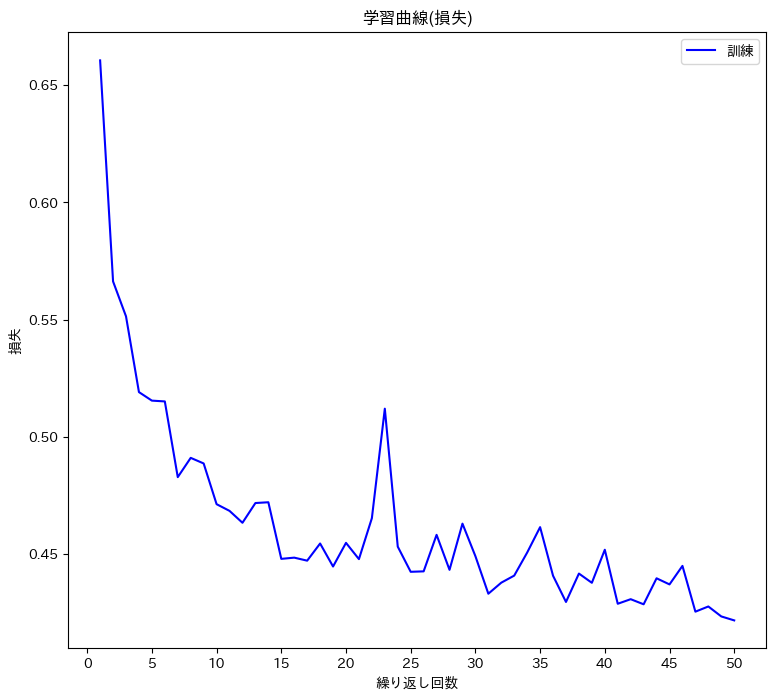

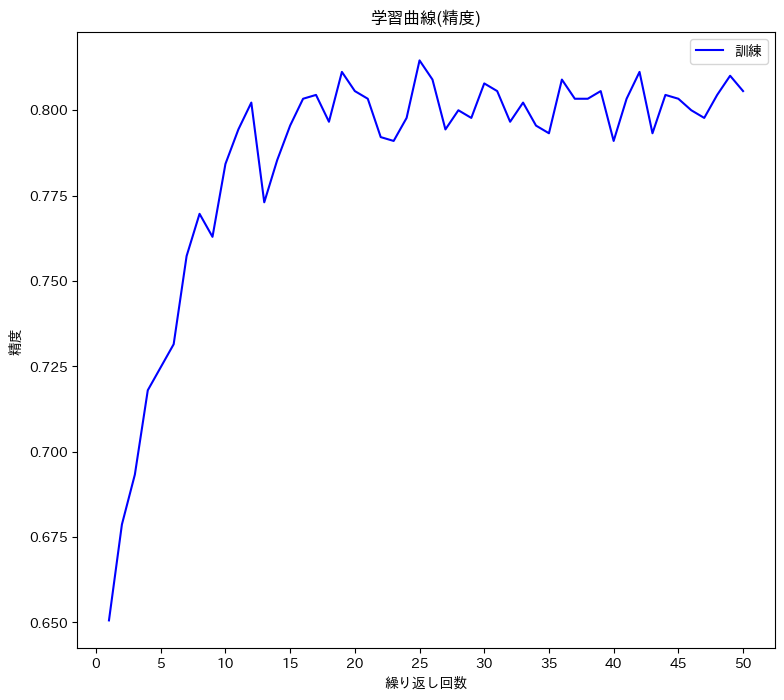

In [167]:
evaluate_history(history)